### Introduction: This is the Jupyter notebook to do the flowing things:

1. Read the `FitShapes.root` files produced by `CombineTools`, and plot the `pre-fit` and `post-fit` shapes, unc added.

env:HWW


### Import necessary modules

In [11]:
import numpy as np
import os
import pandas as pd
import random
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from scipy import interpolate
# from sklearn.metrics import roc_curve, auc
from cycler import cycler
import uproot
# means uproot4
import ROOT
import argparse
import glob
import json
import logging
import os
import pickle as pkl
import warnings

import hist as hist2
from hist.intervals import ratio_uncertainty
import pyarrow
# import utils #local file: utils.py
import yaml
from typing import Dict, List, Union
from dataclasses import dataclass
from copy import deepcopy

# from coffea import hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import vector
# from coffea.nanoevents.methods.vector import PtEtaPhiMLorentzVector

In [12]:
YEAR = "Full-Run2"
FIT = "postfit"

### Define templates dir

In [13]:
MAIN_DIR = "./plots"

plot_dir = f"{MAIN_DIR}/17Apr2025_combined_{FIT}"
_ = os.system(f"mkdir -p {plot_dir}")

### Define combine datacards path

In [14]:
# Modify your path here!!!
cards_dir = f"./"

### plot setting

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=True):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: 
        # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        # You have to access the overflow and underflow bins data like below:
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var
    # Return the updated histogram and variance

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11) # Number: 0-10
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    #cs means to create a CubicSpline object
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    up_error_bar [up_error_bar < 0 ] = 0
    down_error_bar [down_error_bar < 0 ] = 0
    return np.array([down_error_bar, up_error_bar])


# function to find the optimal region with S/sqrt(B)
# not used so far
def optimalcut(shist, bhist):
    n_bins = len(shist)
    best_lower = None
    best_upper = None
    best_s_sqrt_b = 0

    for lower in range(n_bins):
        for upper in range(lower+1, n_bins+1):
            s = np.sum(shist[lower:upper])
            b = np.sum(bhist[lower:upper])
            s_sqrt_b = s / np.sqrt(b + 1)

            if s_sqrt_b > best_s_sqrt_b:
                best_lower = lower
                best_upper = upper
                best_s_sqrt_b = s_sqrt_b

    return best_lower, best_upper, best_s_sqrt_b

def optimalcut_oneside(shist, bhist, epsilon = 0.01):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist)
    best_cut = 0
    best_s_sqrt_b = 0

    for cut in range(n_bins):
        s = np.sum(shist[cut:])
        b = np.sum(bhist[cut:])
        s_sqrt_b = s / np.sqrt(b + epsilon)
        if s_sqrt_b > best_s_sqrt_b:
            best_cut = cut
            best_s_sqrt_b = s_sqrt_b
        
    return best_cut, best_s_sqrt_b

def optimalcut_mid_combine(shist1, shist2, bhist, epsilon = 1):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist1)
    best_cut = 0
    best_combined_sig_two_side = 0

    for cut in range(n_bins):
        s_right_side = np.sum(shist2[cut:])
        b_right_side = np.sum(bhist[cut:])
        s_left_side = np.sum(shist1[:cut])
        b_left_side = np.sum(bhist[:cut])
        s_sqrt_b_right_side = s_right_side / np.sqrt(b_right_side + epsilon)
        s_sqrt_b_left_side = s_left_side / np.sqrt(b_left_side + epsilon)
        combined_sig_two_side = np.sqrt((s_sqrt_b_right_side)**2 + (s_sqrt_b_left_side)**2)
        if combined_sig_two_side > best_combined_sig_two_side:
            best_cut = cut
            best_combined_sig_two_side = combined_sig_two_side
        
    return best_cut, best_combined_sig_two_side


### define functions read FitShape.root files

In [16]:
def read_root(filename = "./FitShapesB.root", region = "SR2a_postfit", process = "ggF"):
    ''' 
    filename:path/to/root
    dir:"QCD"
    name:region from ["CR1",...]
    '''
    with uproot.open(filename) as file:
        hist = file.get(region + "/" + process)
        h = np.array(hist.values())
        var = np.array(hist.variances())        
    return h, var
    # here we defined a simple function to read the predicted QCD,etc. shapes from root file directly
    # but you have to be sure with the accuracy about the root file


### read the FitShapes.root files

In [17]:
#dict about process names and the names in the root files
def load_fitshapes(cards_dir = cards_dir, region = "SR1a", reg_str = "_postfit"):
    name_dict_data = {
        #data
        "data": "data_obs",
    }
    if region in ["SR1a","SR2a","SR1b","SR2b","CR1","CR2"]:
        name_dict_bkg = {
            # 0lepton
            #bkg
            "QCD"  :"CMS_HWW_boosted_qcd_datadriven",
            "TT"   :"ttbar",
            "ST"   :"single_top",
            "WJets":"wjets",
            "Rest" :"rest_bkg",
            "TotalBkg":"TotalBkg"
            #Total bkg
        }
    if region in ["VBF","WJetsCR","TopCR","ggFpt250to350","ggFpt350to500","ggFpt500toInf"]:
        # 1lepton
        name_dict_bkg = {
        "TotalBkg":"TotalBkg",
        "Diboson":"diboson",
        "EWKvjets":"ewkvjets",
        "SingleTop":"singletop",
        # "QCD":"qcd",
        "TTbar":"ttbar",
        "WJetsLNu":"wjets",
        # "WZQQ":"wzqq",
        "DYJets":"zjets",
        # "WZQQorDYJets":"vjets",
        "Fake" :"fake"
        }
    name_dict_sig = {
        #sig
        "TotalSignal":"TotalSig",
        "ggF"        :'ggH_hww',
        "ttH"        :"ttH_hww",
        "VBF"        :"qqH_hww",
        "WH"         :"WH_hww",
        "ZH"         :"ZH_hww",
    }
    name_dict = {**name_dict_bkg , **name_dict_sig , **name_dict_data}
    files_value = {process : {} for process in name_dict}
    files_var   = {process : {} for process in name_dict}
    # regions = ["SR1a","SR1b","CR1","SR2a","SR2b","CR2"]
    # for region in regions:
    name_dict_tmp = {**name_dict_bkg , **name_dict_data} if region.startswith("CR") else name_dict
    for process in name_dict_tmp:
        print("NOW",process)
        files_value[process],files_var[process] = read_root(filename = f"{cards_dir}/FitShapesB.root",region = region + reg_str, process = name_dict_tmp[process])
        # print("done",region, process)
    if region.startswith("CR"):
        for process_tmp in name_dict_sig :
            #random samples to extract the bins info
            value_eg, var_eg = read_root(filename = f"{cards_dir}/FitShapesB.root",region = "SR1a" + reg_str, process = "ttbar")
            files_value[process_tmp],files_var[process_tmp] = np.zeros_like(value_eg),np.zeros_like(var_eg)
            # print("done",region, process_tmp)
    return files_value,files_var

### Plot variables

In [25]:
from matplotlib.cm import get_cmap
hep.style.use("CMS")
def fitshapes_plot(arrays,arrays_var, plot_name: str, x_name: str, region = 'PS',othertext = "", year='2018', bins=40, x_min=0, x_max=2000, density=False, overflow=False, underflow=False, fraction_log=False,log = False,blind = True, blindMC = False, nametext = "",optimal_cut = True, deco = False,postfit_files = ""):
    LUMI = {"2016APV": 19.52, "2016": 16.81, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    bin_width = (x_max-x_min)/bins
    ## canvas initializing
    f = plt.figure(figsize=(10, 12))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    hep.cms.label(loc = 1, data=True,  ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    # Ratio panel
    ax1 = f.add_subplot(gs[1])

    # analyze
    stacked = {'h': {}, 'var': {}} 
    individual = {'h': {}, 'var': {}}
    BKG = ["QCD","TT","ST","WJets","Rest"]
    name_dict_sig = {
        #sig
        "TotalSignal":"TotalSig",
        "ggF"        :'ggH_hww',
        "ttH"        :"ttH_hww",
        "VBF"        :"qqH_hww",
        "WH"         :"WH_hww",
        "ZH"         :"ZH_hww",
    }
    for (k,v) in arrays.items():
        # print(k)
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        # hist.fill(values)
        # h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        h = arrays[k]
        var = arrays_var[k]
        # here the var are just usual standard variance
        if k in BKG: 
            stacked['h'][k] = h
            stacked['var'][k] = var
        elif k in name_dict_sig or k == "data":
            individual['h'][k] = h
            individual['var'][k] = var        
    #plot
    SIG_COLOR={'TotalSignal': 'black',"ggF":"pink","WH":"green","ZH":"blue","ttH":"yellow","VBF":"aqua"}
    SIG_DECO_COLOR = {'TotalSignal': 'black',r"$H^{4q}$":"green",r"$H^{3q}$":"orange","W":"blue","top":"purple","Z":"yellow",r"$H^{lqq}$":"cyan","g/q":"pink","rest":"gray"}
    
    if len(stacked['h'].keys())>0:
        BKG_list = ["Rest","WJets","TT","ST","QCD"]
        # err_list = [  np.nan_to_num(error_bar(stacked['h'][k], stacked['var'][k], type = "mc"), nan = 0) for k in BKG_list]
        h_list = [stacked['h'][k] for k in BKG_list]
        label_list = BKG_list
        # colors = ["#1f77b4", "#ff7f0e", "#2ca02c","green","#d62728"] #old color regime
        colors = ["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1"] #latest color regime according to:https://cms-analysis.docs.cern.ch/guidelines/plotting/colors/#1d-histogramstackplot
        # corresponds to Rest, WJets, TT, ST, QCD
        # colors = colors[::-1]
        hep.histplot(h_list, bins=hist.axes[0].edges, label=label_list,  histtype='fill', density=density, stack=True, linewidth=2, ax=ax,color = colors)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        # bkg_err = np.sum(err_list ,  axis=0)
        bkg_err = np.sqrt(arrays_var["TotalBkg"]) #directly from fitshapes.root
        # print("err",bkg_err)
        bin_edges = np.linspace(x_min, x_max, bins+1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        
        #plot grey bar for systematic uncertainties
        # ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
        
        #add dashed region for systematic uncertainties
        errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 0,
            "alpha": 0.4,
            "label":"Syst. Unc.",
        }
        ax.stairs(values = bkg_h + bkg_err, baseline = bkg_h - bkg_err, edges = hist.axes[0].edges, **errps)
        
    # Scale the signal according to total BKG to make it visiable:
    
    NORM_s1=np.sum(bkg_h)/(np.sum(individual["h"]["TotalSignal"])+0.000001)
    print("Should scale signal * ",NORM_s1)
    if                       NORM_s1>=300000: NORM_s1=300000
    elif  300000>NORM_s1 and NORM_s1>=100000: NORM_s1= 100000
    elif  100000>NORM_s1 and NORM_s1>= 30000: NORM_s1= 30000
    elif   30000>NORM_s1 and NORM_s1>= 10000: NORM_s1=  10000
    elif   10000>NORM_s1 and NORM_s1>=  3000: NORM_s1=  3000
    elif    3000>NORM_s1 and NORM_s1>=  1000: NORM_s1=   1000
    elif    1000>NORM_s1 and NORM_s1>=   300: NORM_s1=   300
    elif     300>NORM_s1 and NORM_s1>=   100: NORM_s1=    100
    elif     100>NORM_s1 and NORM_s1>=    30: NORM_s1=    30
    elif      30>NORM_s1 and NORM_s1>=    10: NORM_s1=     10
    else                                    : NORM_s1=     1   
    
    # print(individual['h'].items())
    for (k,h) in individual['h'].items():
        if k=='data': #data
            
            err_data = error_bar(h, individual['var'][k], type='data')
            # err_data = np.sqrt(arrays_var["data"])
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err_data, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            

            err_bkg = np.sqrt(arrays_var["TotalBkg"])
            h_bkg = arrays["TotalBkg"]
            
            #define the pulls
            pull = (h - bkg_h) / err_data[0]
            
            # plot pulls, err for pull is: σ_sys/σ_data
            hep.histplot(pull, bins=hist.axes[0].edges, yerr = (err_data[0] / err_data[0], err_data[0] / err_data[0] ), color='black', histtype='errorbar', density=density, stack=False, ax=ax1, label = "Pull")    
            
            # then add shaded error to ratio plot
            errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 1,
            "alpha": 0.4,
            "label":r"$\sigma_{syst} / \sigma_{stat}$"
            }
            
            ax1.stairs(values = err_bkg / err_data[1], baseline = - err_bkg / err_data[0], edges = hist.axes[0].edges, **errps)
        
        else:  # signal
            # print("sig",k)
            if h[1] == 0 : 
                print(k,"is 0")
                optimal_cut == False
                continue 
                #control region doesn't have signal yields
            if deco != True:
                if k in ["TotalSignal","ggF","WH","ZH","ttH","VBF"]:
                    # err = error_bar(h, individual['var'][k], type='mc')
                    
                    #directly use the unc from combine output
                    err = np.sqrt(individual['var'][k])
                    # hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
                    
                    #TODO: ignore err
                    hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])

    for (k,h) in individual['h'].items():
        if k == "TotalSignal":
            y = h / err_data[0]
            # for signal, just keep the original unc style
            # hep.histplot(y * 5, bins=hist.axes[0].edges, histtype='fill', label= r"$5\times Signal /\sigma_{stat}$", density=density, stack=False, ax=ax1, color="red")
            
            hep.histplot(y, bins=hist.axes[0].edges, histtype='fill', label= r"$Signal /\sigma_{stat}$", density=density, stack=False, ax=ax1, color="red")
            #TODO: ignore err
            
    # 手动添加需要的标签到 ax1 图例
    # ax1.legend([None, "Pull", r"$\frac{5\times Signal}{\sigma_{data}}$"], loc="upper right", ncol=2, fontsize=14)
    ax1.plot([x_min,x_max], [0,0], color='black', linestyle='dashed')
    ax.set_xlim(x_min, x_max)
    if log:
        ax.set_yscale('log')
        ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1e1)
    else:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*1.3)

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    # ax1.set_xticklabels([])
    
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        # ax1.set_ylim(0, 2)
        if region.startswith("SR"): ax1.set_ylim(-4, 4)
        else : ax1.set_ylim(-4, 4)
    ax1.set_ylabel(r'$Pull: \frac{Data\ -\ Pred.}{\sigma_{stat}}$', ha='center', fontsize=20)
    # ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)
    # ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    plt.xticks(size=14)
    plt.yticks(size=14)
    
    if blind:
        plt.text(0.05,0.83,region ,fontsize=17, color="black", ha='left',transform=ax.transAxes)
        plt.text(0.05,0.76,othertext,fontsize=17, color="black", ha='left',transform=ax.transAxes)
    else:
        plt.text(0.05,0.83,region,fontsize=17, color="black", ha='left',transform=ax.transAxes)
        plt.text(0.05,0.73,othertext,fontsize=17, color="black", ha='left',transform=ax.transAxes)        
    
    ax.legend(loc="upper right", ncol=2, frameon=False, fontsize=14)
    ax1.legend(loc="upper right", ncol = 3, frameon=False, fontsize=16)                   
    
    
    suffix = '_AU' if density else ''
    if deco: suffix += "_DECO"
    path_str = plot_dir
    if not os.path.exists(path_str):
        os.makedirs(path_str)
    othertext = othertext.replace(",","")
    othertext = othertext.replace(" ","")
    othertext = othertext.replace("(","")
    othertext = othertext.replace(")","")
    othertext = othertext.replace("=","")
    plt.savefig(f"{path_str}/{year}_{plot_name}{suffix}_{region}{othertext}{nametext}.pdf", bbox_inches='tight')
    plt.show()

In [26]:
def fitshapes_runPlots(region = "PS", reg_str = f"_{FIT}",nametext = "", othertext = "",year=f"{YEAR}"): 
    arrays,arrays_var = load_fitshapes(region = region,reg_str = reg_str)
    fitshapes_plot(arrays,arrays_var,  region = region, nametext = nametext, othertext = othertext,plot_name='MH_Reco', x_name=r'$jet_{a}:MET\ recovery\ mass$', x_max=250, x_min=50, bins=20, year=year,deco = False)

### plot order = (3,6) post-fit fitshapes

NOW QCD
NOW TT
NOW ST
NOW WJets
NOW Rest
NOW TotalBkg
NOW TotalSignal
NOW ggF
NOW ttH
NOW VBF
NOW WH
NOW ZH
NOW data
Should scale signal *  6396.051703979537


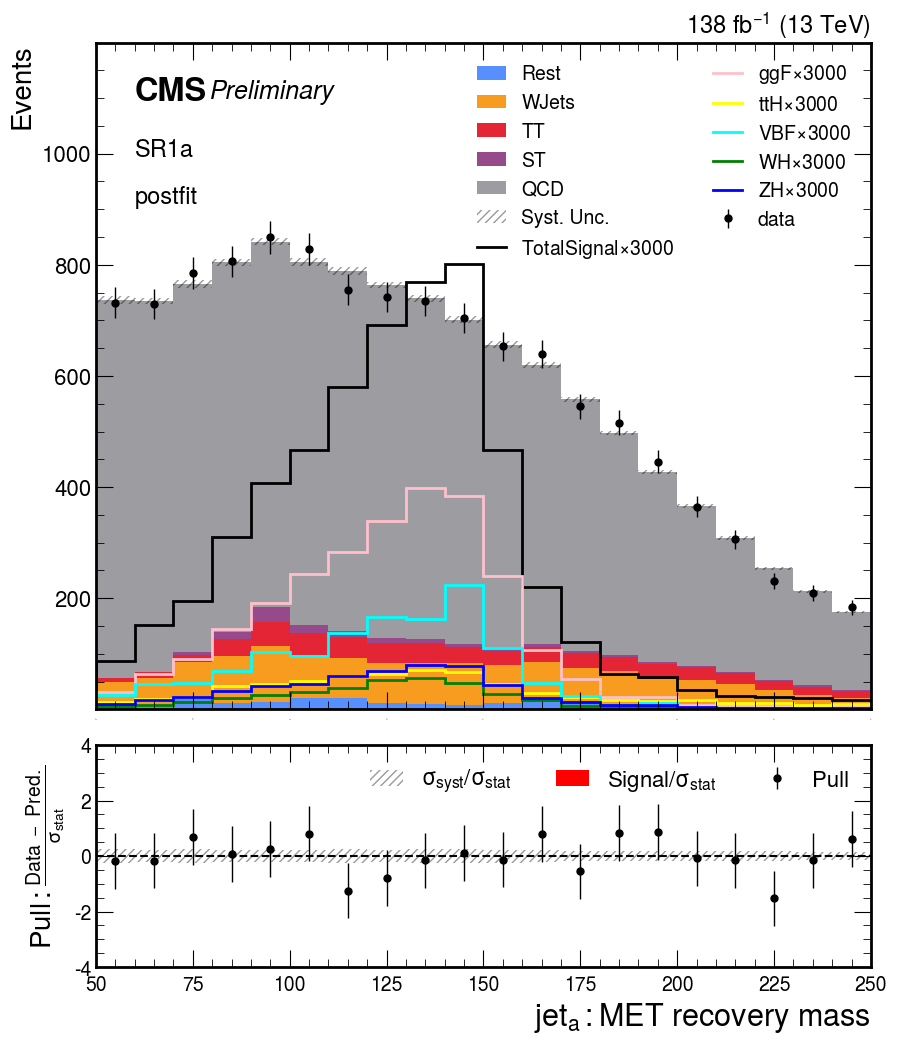

NOW QCD
NOW TT
NOW ST
NOW WJets
NOW Rest
NOW TotalBkg
NOW TotalSignal
NOW ggF
NOW ttH
NOW VBF
NOW WH
NOW ZH
NOW data
Should scale signal *  81146.94990886486


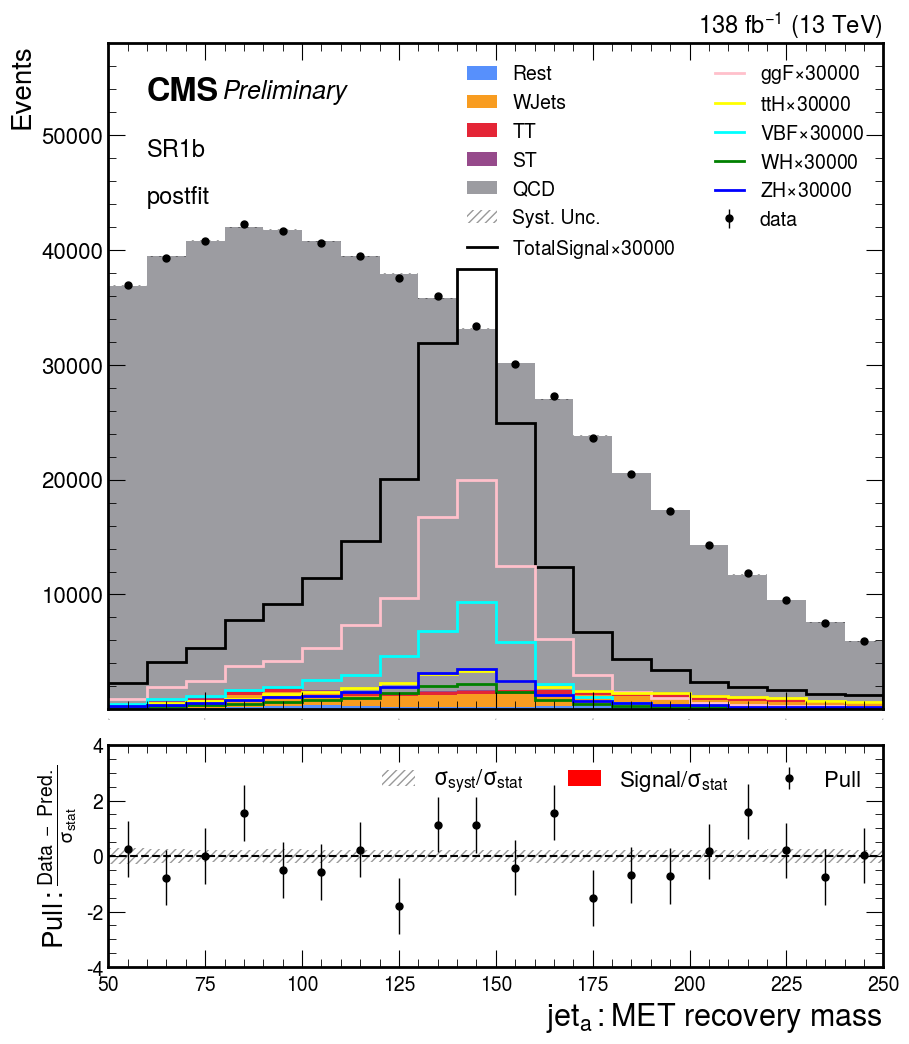

NOW QCD
NOW TT
NOW ST
NOW WJets
NOW Rest
NOW TotalBkg
NOW data
Should scale signal *  107816416000000.0
TotalSignal is 0
ggF is 0
ttH is 0
VBF is 0
WH is 0
ZH is 0


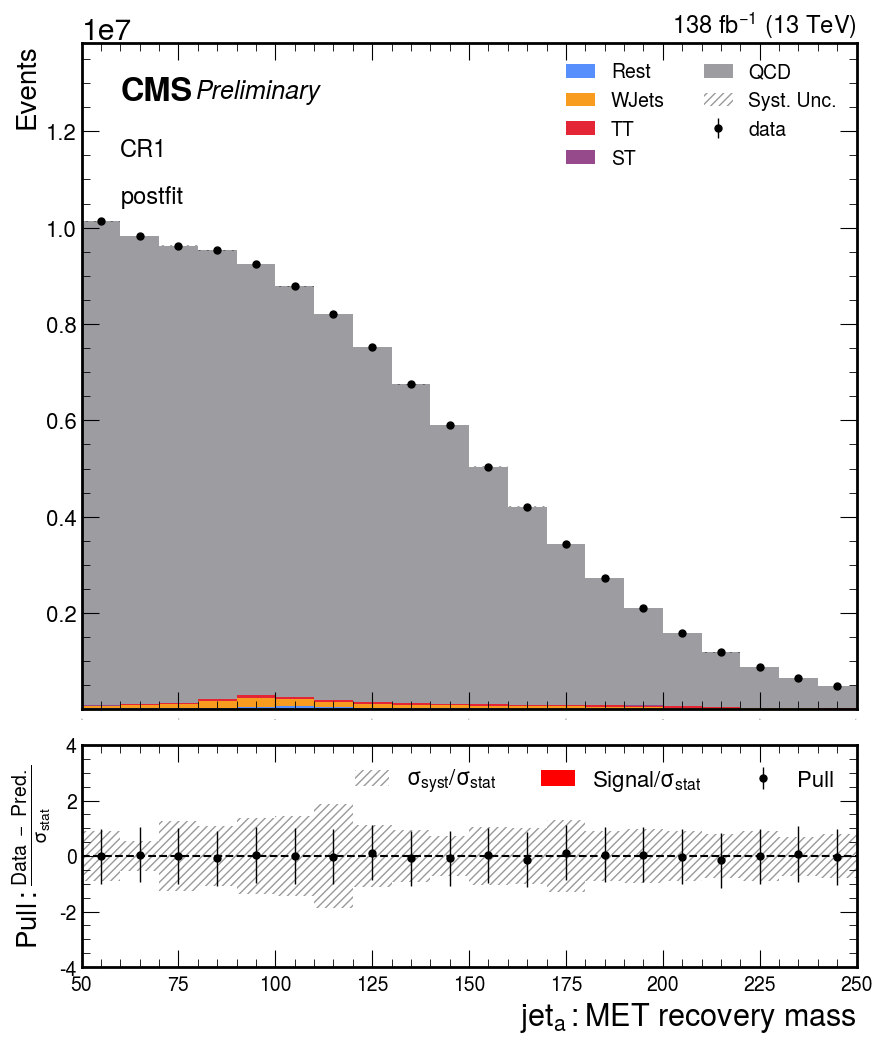

NOW QCD
NOW TT
NOW ST
NOW WJets
NOW Rest
NOW TotalBkg
NOW TotalSignal
NOW ggF
NOW ttH
NOW VBF
NOW WH
NOW ZH
NOW data
Should scale signal *  1109.9401791586545


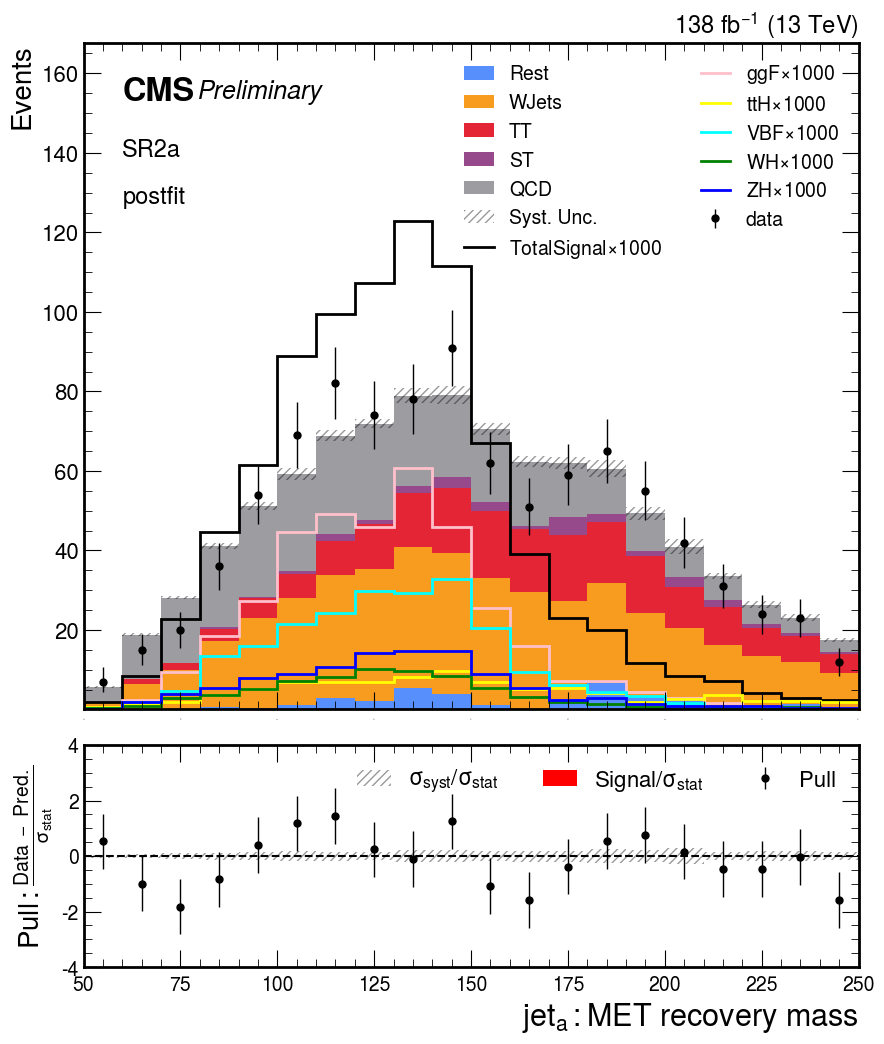

NOW QCD
NOW TT
NOW ST
NOW WJets
NOW Rest
NOW TotalBkg
NOW TotalSignal
NOW ggF
NOW ttH
NOW VBF
NOW WH
NOW ZH
NOW data
Should scale signal *  15291.25443762681


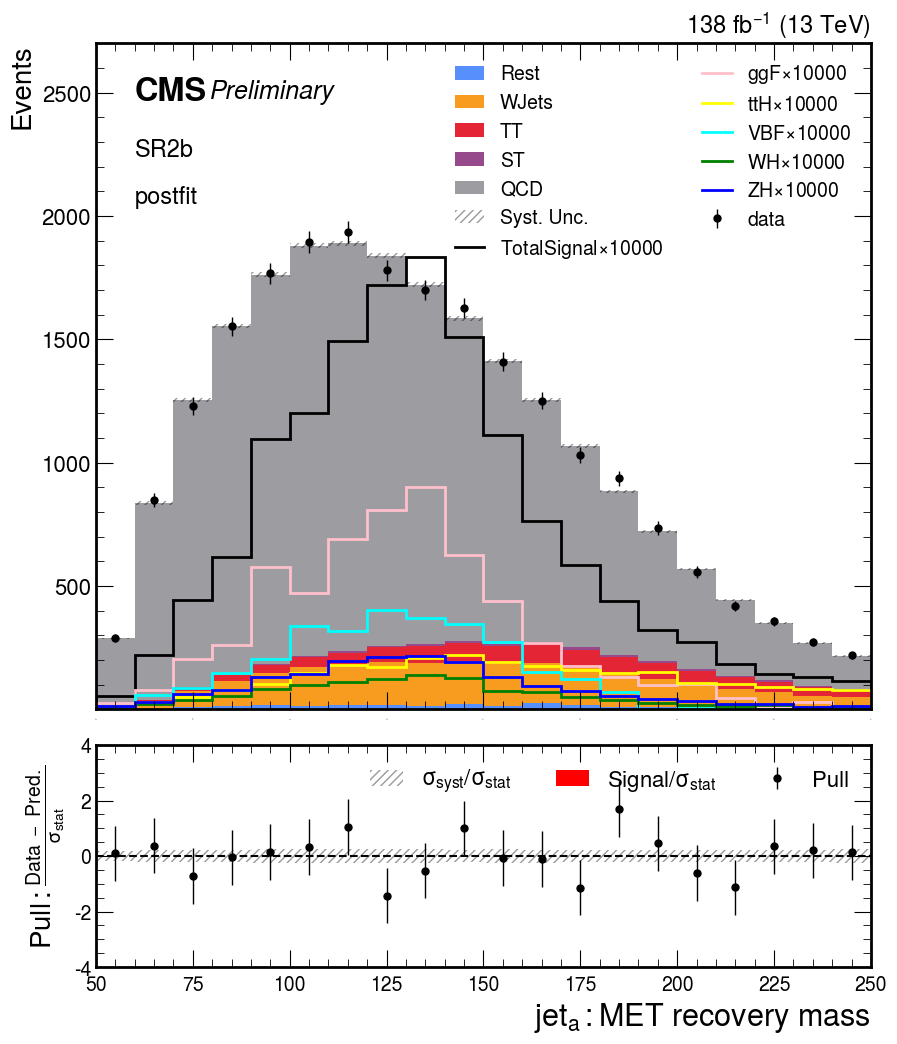

NOW QCD
NOW TT
NOW ST
NOW WJets
NOW Rest
NOW TotalBkg
NOW data
Should scale signal *  5263082500000.0
TotalSignal is 0
ggF is 0
ttH is 0
VBF is 0
WH is 0
ZH is 0


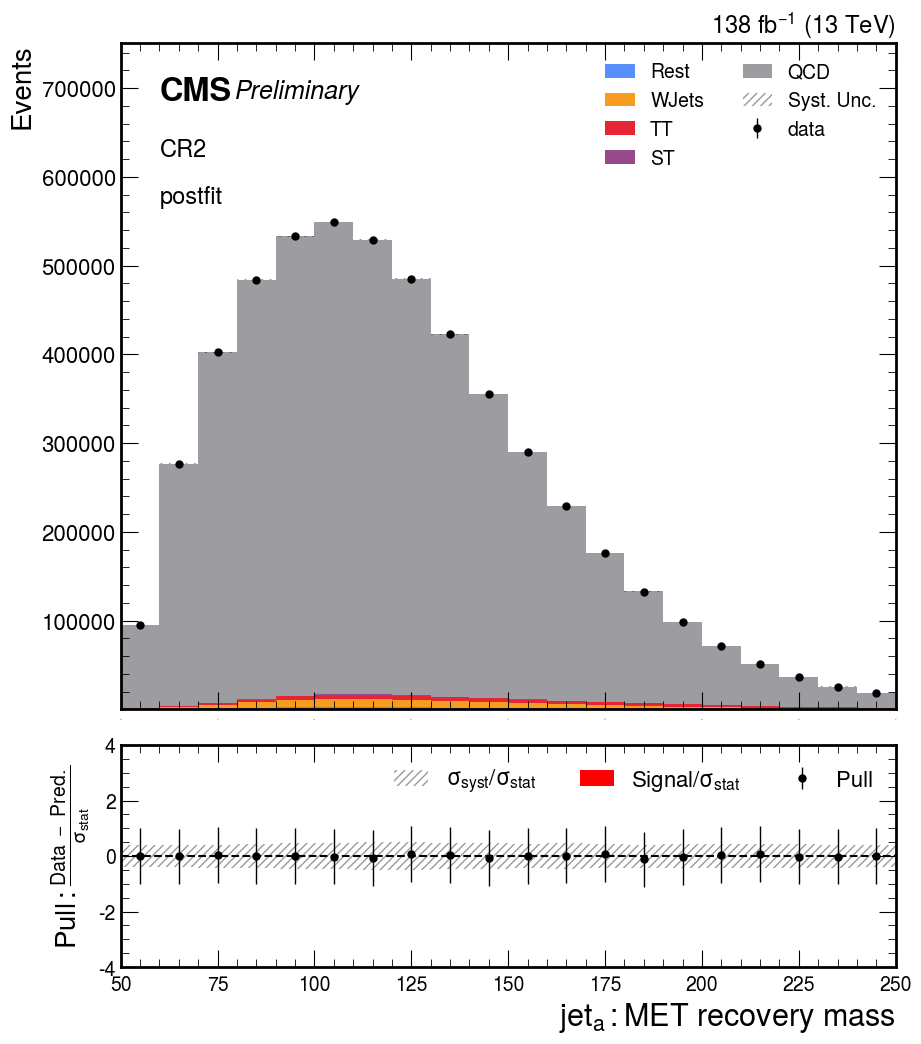

In [27]:
fitshapes_runPlots(region = "SR1a", othertext =  f"{FIT}")
fitshapes_runPlots(region = "SR1b", othertext =  f"{FIT}")
fitshapes_runPlots(region = "CR1",   othertext = f"{FIT}")
fitshapes_runPlots(region = "SR2a", othertext =  f"{FIT}")
fitshapes_runPlots(region = "SR2b", othertext =  f"{FIT}")
fitshapes_runPlots(region = "CR2",   othertext = f"{FIT}")

### Plot 1lepton

In [30]:
from matplotlib.cm import get_cmap
hep.style.use("CMS")
def fitshapes_plot_1lep(arrays,arrays_var, plot_name: str, x_name: str, region = 'PS',othertext = "", year='2018', bins=40, x_min=0, x_max=2000, density=False, overflow=False, underflow=False, fraction_log=False,log = False,blind = True, blindMC = False, nametext = "",optimal_cut = True, deco = False,postfit_files = ""):
    LUMI = {"2016APV": 19.52, "2016": 16.81, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    bin_width = (x_max-x_min)/bins
    ## canvas initializing
    f = plt.figure(figsize=(10, 12))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    hep.cms.label(loc = 1, data=True, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    # Ratio panel
    ax1 = f.add_subplot(gs[1])

    # analyze
    stacked = {'h': {}, 'var': {}} 
    individual = {'h': {}, 'var': {}}
    BKG = ["QCD","TT","ST","WJets","Rest"]
    BKG_dict = {
    # "QCD": "tab:orange",
    "WJetsLNu": "tab:green",
    "TTbar": "tab:blue",
    "Diboson": "orchid",
    "SingleTop": "tab:cyan",
    # "WJetsLNu_unmatched": "tab:grey",
    # "WJetsLNu_matched": "tab:green",
    "EWKvjets": "tab:grey",
    # TODO: make sure it's WZQQ is NLO in next iteration
    "DYJets": "tab:purple",
    # "WZQQ": "khaki",
    # "WZQQorDYJets": "khaki",
    "Fake": "tab:orange",
    }
    BKG = list(BKG_dict.keys())
    name_dict_sig = {
        #sig
        "TotalSignal":"TotalSig",
        "ggF"        :'ggH_hww',
        "ttH"        :"ttH_hww",
        "VBF"        :"qqH_hww",
        "WH"         :"WH_hww",
        "ZH"         :"ZH_hww",
    }
    for (k,v) in arrays.items():
        # print(k)
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        # hist.fill(values)
        # h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        h = arrays[k]
        var = arrays_var[k]
        # here the var are just usual standard variance
        if k in BKG: 
            stacked['h'][k] = h
            stacked['var'][k] = var
        elif k in name_dict_sig or k == "data":
            individual['h'][k] = h
            individual['var'][k] = var        
    #plot
    SIG_COLOR={'TotalSignal': 'black',"ggF":"pink","WH":"green","ZH":"blue","ttH":"yellow","VBF":"aqua"}
    SIG_DECO_COLOR = {'TotalSignal': 'black',r"$H^{4q}$":"green",r"$H^{3q}$":"orange","W":"blue","top":"purple","Z":"yellow",r"$H^{lqq}$":"cyan","g/q":"pink","rest":"gray"}
    
    if len(stacked['h'].keys())>0:
        # BKG_list = ["Rest","WJets","TT","ST","QCD"]
        # BKG_list = ["Rest","WJets","TT","ST","QCD"]
        BKG_list = BKG
        # err_list = [  np.nan_to_num(error_bar(stacked['h'][k], stacked['var'][k], type = "mc"), nan = 0) for k in BKG_list]
        h_list = [stacked['h'][k] for k in BKG_list]
        label_list = BKG_list
        # colors = ["#1f77b4", "#ff7f0e", "#2ca02c","green","#d62728"] #old color regime
        # colors = ["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1"] #latest color regime according to:https://cms-analysis.docs.cern.ch/guidelines/plotting/colors/#1d-histogramstackplot
        colors = list(BKG_dict.values())
        # corresponds to Rest, WJets, TT, ST, QCD
        # colors = colors[::-1]
        hep.histplot(h_list, bins=hist.axes[0].edges, label=label_list,  histtype='fill', density=density, stack=True, linewidth=2, ax=ax,color = colors)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        # bkg_err = np.sum(err_list ,  axis=0)
        bkg_err = np.sqrt(arrays_var["TotalBkg"]) #directly from fitshapes.root
        # print("err",bkg_err)
        bin_edges = np.linspace(x_min, x_max, bins+1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        
        #plot grey bar for systematic uncertainties
        # ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
        
        #add dashed region for systematic uncertainties
        errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 0,
            "alpha": 0.4,
            "label":"Syst. Unc.",
        }
        ax.stairs(values = bkg_h + bkg_err, baseline = bkg_h - bkg_err, edges = hist.axes[0].edges, **errps)
        
    # Scale the signal according to total BKG to make it visiable:
    
    NORM_s1=np.sum(bkg_h)/(np.sum(individual["h"]["TotalSignal"])+0.000001)
    print("Should scale signal * ",NORM_s1)
    if                       NORM_s1>=300000: NORM_s1=300000
    elif  300000>NORM_s1 and NORM_s1>=100000: NORM_s1= 100000
    elif  100000>NORM_s1 and NORM_s1>= 30000: NORM_s1= 30000
    elif   30000>NORM_s1 and NORM_s1>= 10000: NORM_s1=  10000
    elif   10000>NORM_s1 and NORM_s1>=  3000: NORM_s1=  3000
    elif    3000>NORM_s1 and NORM_s1>=  1000: NORM_s1=   1000
    elif    1000>NORM_s1 and NORM_s1>=   300: NORM_s1=   300
    elif     300>NORM_s1 and NORM_s1>=   100: NORM_s1=    100
    elif     100>NORM_s1 and NORM_s1>=    30: NORM_s1=    30
    elif      30>NORM_s1 and NORM_s1>=    10: NORM_s1=     10
    else                                    : NORM_s1=     1   
    
    # print(individual['h'].items())
    for (k,h) in individual['h'].items():
        if k=='data': #data
            
            err_data = error_bar(h, individual['var'][k], type='data')
            # err_data = np.sqrt(arrays_var["data"])
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err_data, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            

            err_bkg = np.sqrt(arrays_var["TotalBkg"])
            h_bkg = arrays["TotalBkg"]
            
            #define the pulls
            pull = (h - bkg_h) / err_data[0]
            
            # plot pulls, err for pull is: σ_sys/σ_data
            hep.histplot(pull, bins=hist.axes[0].edges, yerr = (err_data[0] / err_data[0], err_data[0] / err_data[0] ), color='black', histtype='errorbar', density=density, stack=False, ax=ax1, label = "Pull")    
            
            # then add shaded error to ratio plot
            errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 1,
            "alpha": 0.4,
            "label":r"$\sigma_{syst} / \sigma_{stat}$"
            }
            
            ax1.stairs(values = err_bkg / err_data[1], baseline = - err_bkg / err_data[0], edges = hist.axes[0].edges, **errps)
        
        else:  # signal
            # print("sig",k)
            if h[1] == 0 : 
                print(k,"is 0")
                optimal_cut == False
                continue 
                #control region doesn't have signal yields
            if deco != True:
                if k in ["TotalSignal","ggF","WH","ZH","ttH","VBF"]:
                    # err = error_bar(h, individual['var'][k], type='mc')
                    
                    #directly use the unc from combine output
                    err = np.sqrt(individual['var'][k])
                    # hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
                    
                    #TODO: ignore err
                    hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
                

    for (k,h) in individual['h'].items():
        if k == "TotalSignal":
            y = h / err_data[0]
            # for signal, just keep the original unc style
            # hep.histplot(y * 5, bins=hist.axes[0].edges, histtype='fill', label= r"$5\times Signal /\sigma_{stat}$", density=density, stack=False, ax=ax1, color="red")
            hep.histplot(y, bins=hist.axes[0].edges, histtype='fill', label= r"$Signal /\sigma_{stat}$", density=density, stack=False, ax=ax1, color="red")
    
    # 手动添加需要的标签到 ax1 图例
    # ax1.legend([None, "Pull", r"$\frac{5\times Signal}{\sigma_{data}}$"], loc="upper right", ncol=2, fontsize=14)
    ax1.plot([x_min,x_max], [0,0], color='black', linestyle='dashed')
    ax.set_xlim(x_min, x_max)
    if log:
        ax.set_yscale('log')
        ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1e1)
    else:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*1.3)

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    # ax1.set_xticklabels([])
    
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        # ax1.set_ylim(0, 2)
        if region.startswith("SR"): ax1.set_ylim(-4, 4)
        else : ax1.set_ylim(-4, 4)
    ax1.set_ylabel(r'$Pull: \frac{Data\ -\ Pred.}{\sigma_{stat}}$', ha='center', fontsize=20)
    # ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)
    # ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    plt.xticks(size=14)
    plt.yticks(size=14)
    
    if blind:
        plt.text(0.05,0.83,region ,fontsize=17, color="black", ha='left',transform=ax.transAxes)
        plt.text(0.05,0.76,othertext,fontsize=17, color="black", ha='left',transform=ax.transAxes)
    else:
        plt.text(0.05,0.83,region,fontsize=17, color="black", ha='left',transform=ax.transAxes)
        plt.text(0.05,0.73,othertext,fontsize=17, color="black", ha='left',transform=ax.transAxes)        
    
    ax.legend(loc="upper right", ncol=3, frameon=False, fontsize=14)
    ax1.legend(loc="upper right", ncol = 3, frameon=False, fontsize=16)                   
    
    
    suffix = '_AU' if density else ''
    if deco: suffix += "_DECO"
    path_str = plot_dir
    if not os.path.exists(path_str):
        os.makedirs(path_str)
    othertext = othertext.replace(",","")
    othertext = othertext.replace(" ","")
    othertext = othertext.replace("(","")
    othertext = othertext.replace(")","")
    othertext = othertext.replace("=","")
    plt.savefig(f"{path_str}/lepton1_{year}_{plot_name}{suffix}_{region}{othertext}{nametext}.pdf", bbox_inches='tight')
    plt.show()

NOW TotalBkg
NOW Diboson
NOW EWKvjets
NOW SingleTop
NOW TTbar
NOW WJetsLNu
NOW DYJets
NOW Fake
NOW TotalSignal
NOW ggF
NOW ttH
NOW VBF
NOW WH
NOW ZH
NOW data
Should scale signal *  88.2894975828241


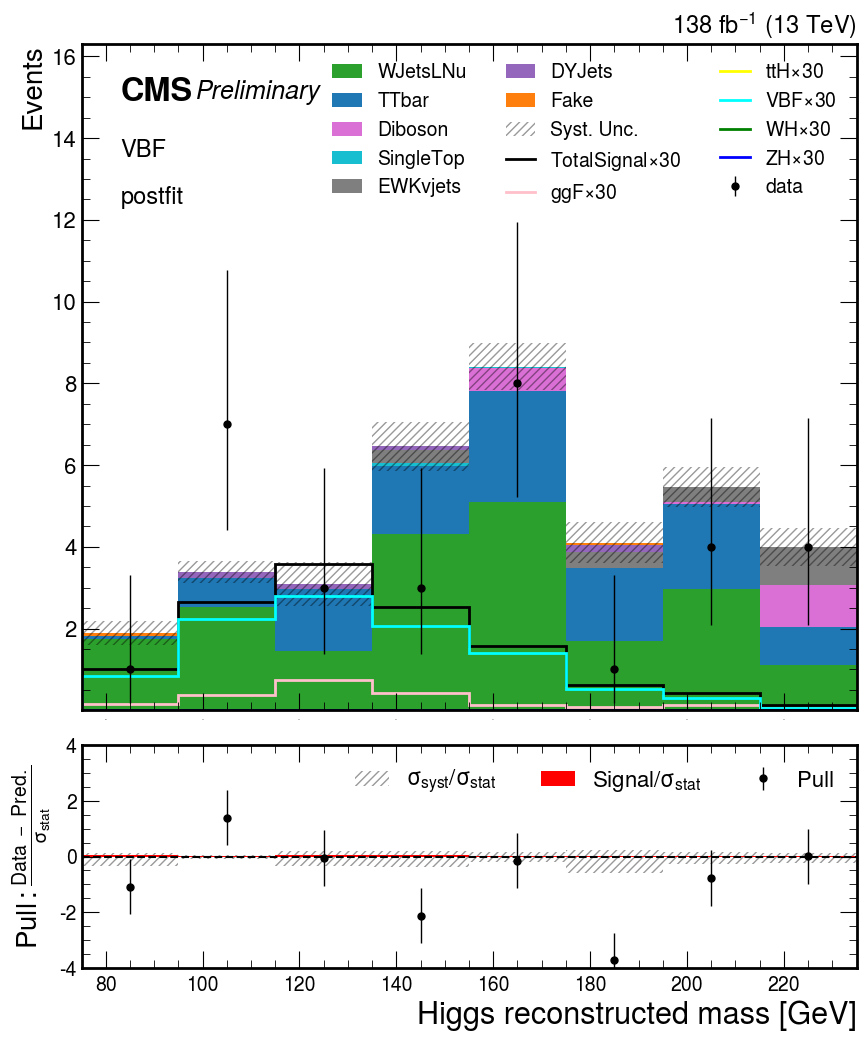

NOW TotalBkg
NOW Diboson
NOW EWKvjets
NOW SingleTop
NOW TTbar
NOW WJetsLNu
NOW DYJets
NOW Fake
NOW TotalSignal
NOW ggF
NOW ttH
NOW VBF
NOW WH
NOW ZH
NOW data
Should scale signal *  304.0016775752805


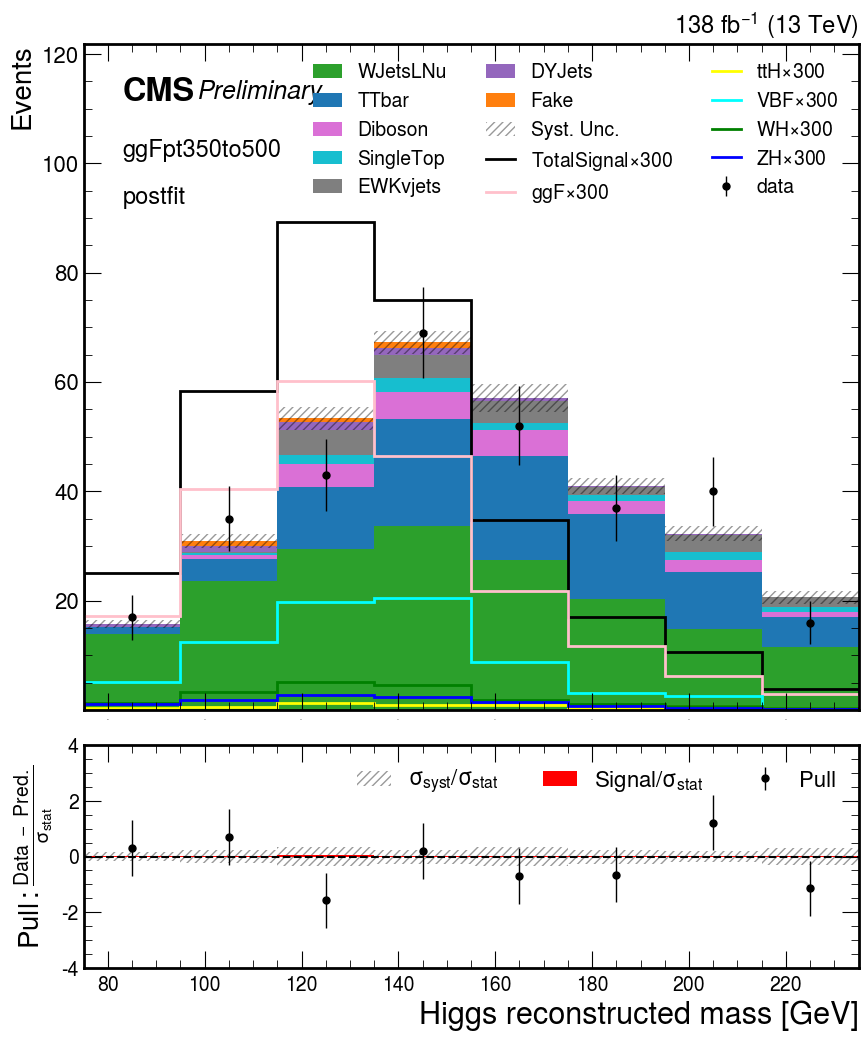

NOW TotalBkg
NOW Diboson
NOW EWKvjets
NOW SingleTop
NOW TTbar
NOW WJetsLNu
NOW DYJets
NOW Fake
NOW TotalSignal
NOW ggF
NOW ttH
NOW VBF
NOW WH
NOW ZH
NOW data
Should scale signal *  338.95465838467635


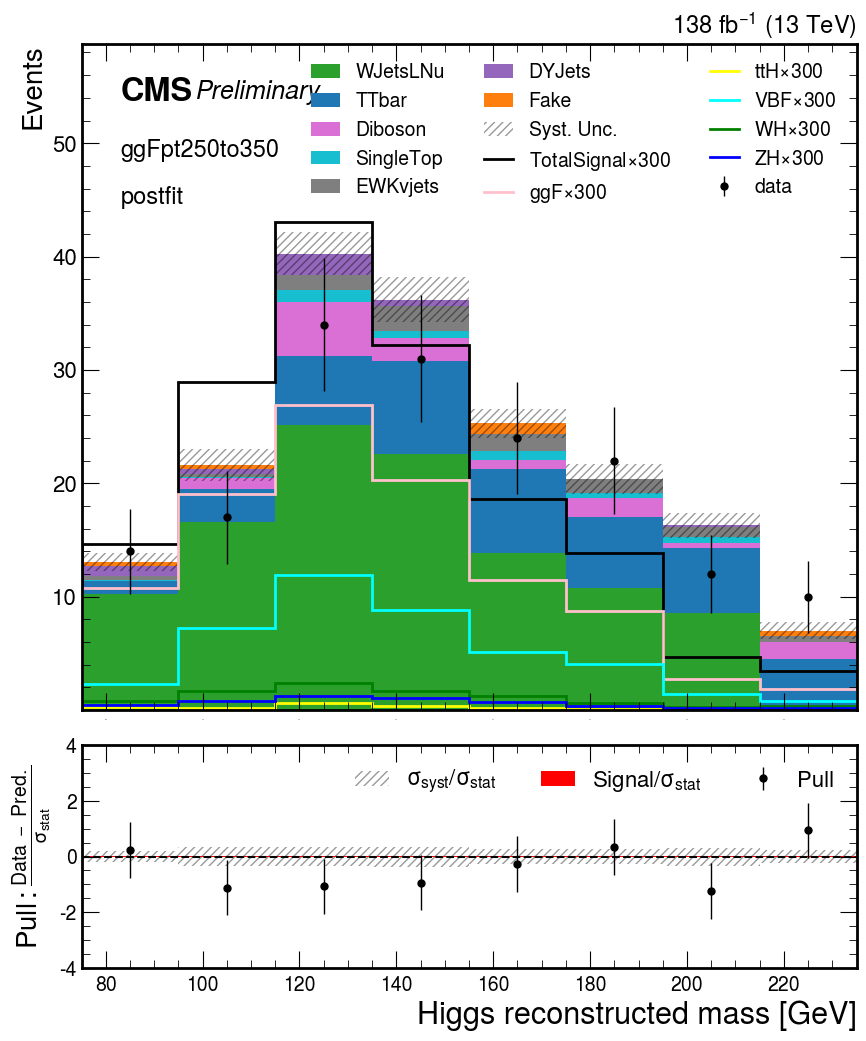

NOW TotalBkg
NOW Diboson
NOW EWKvjets
NOW SingleTop
NOW TTbar
NOW WJetsLNu
NOW DYJets
NOW Fake
NOW TotalSignal
NOW ggF
NOW ttH
NOW VBF
NOW WH
NOW ZH
NOW data
Should scale signal *  375.62366290940577


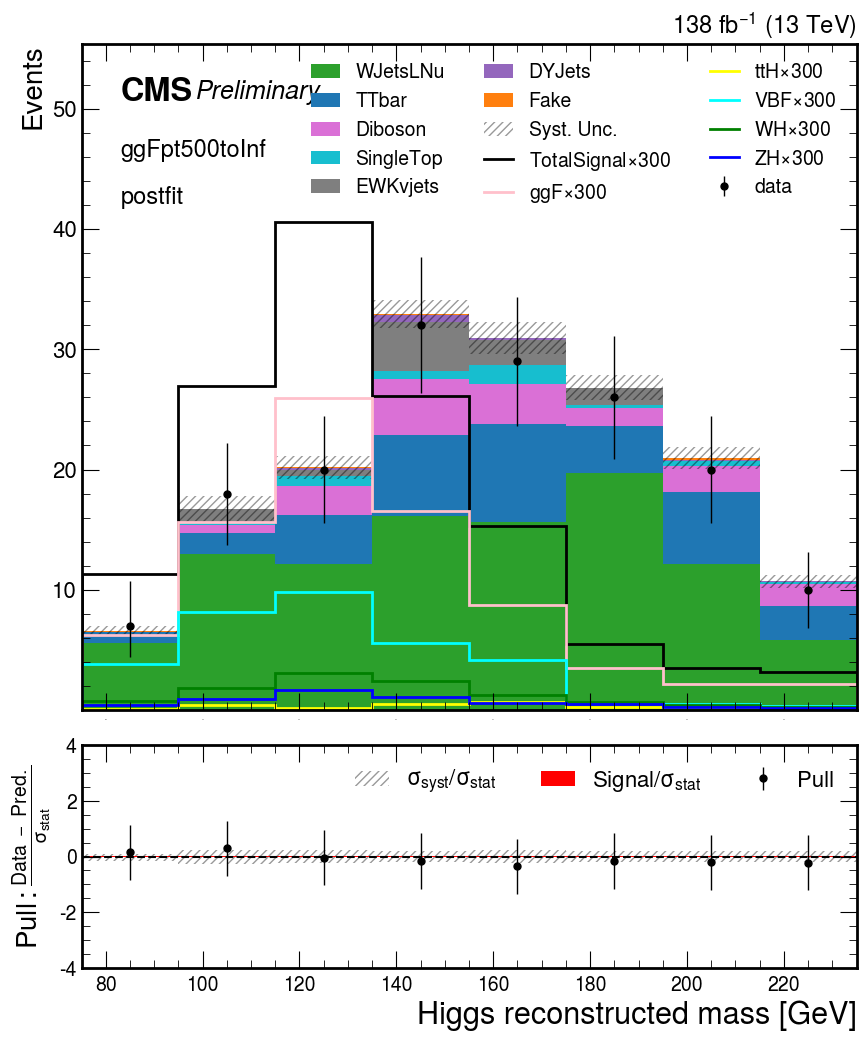

NOW TotalBkg
NOW Diboson
NOW EWKvjets
NOW SingleTop
NOW TTbar
NOW WJetsLNu
NOW DYJets
NOW Fake
NOW TotalSignal
NOW ggF
NOW ttH
NOW VBF
NOW WH
NOW ZH
NOW data
Should scale signal *  990.6968317001268


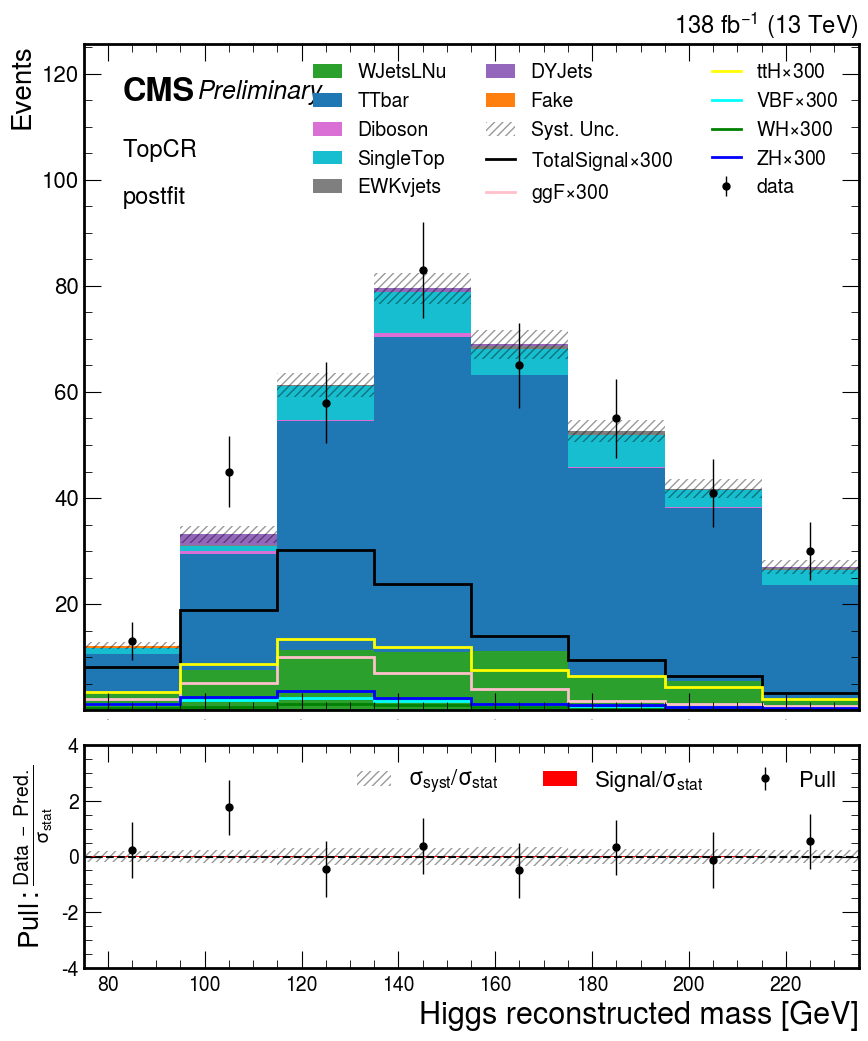

NOW TotalBkg
NOW Diboson
NOW EWKvjets
NOW SingleTop
NOW TTbar
NOW WJetsLNu
NOW DYJets
NOW Fake
NOW TotalSignal
NOW ggF
NOW ttH
NOW VBF
NOW WH
NOW ZH
NOW data
Should scale signal *  1527.0893386784517


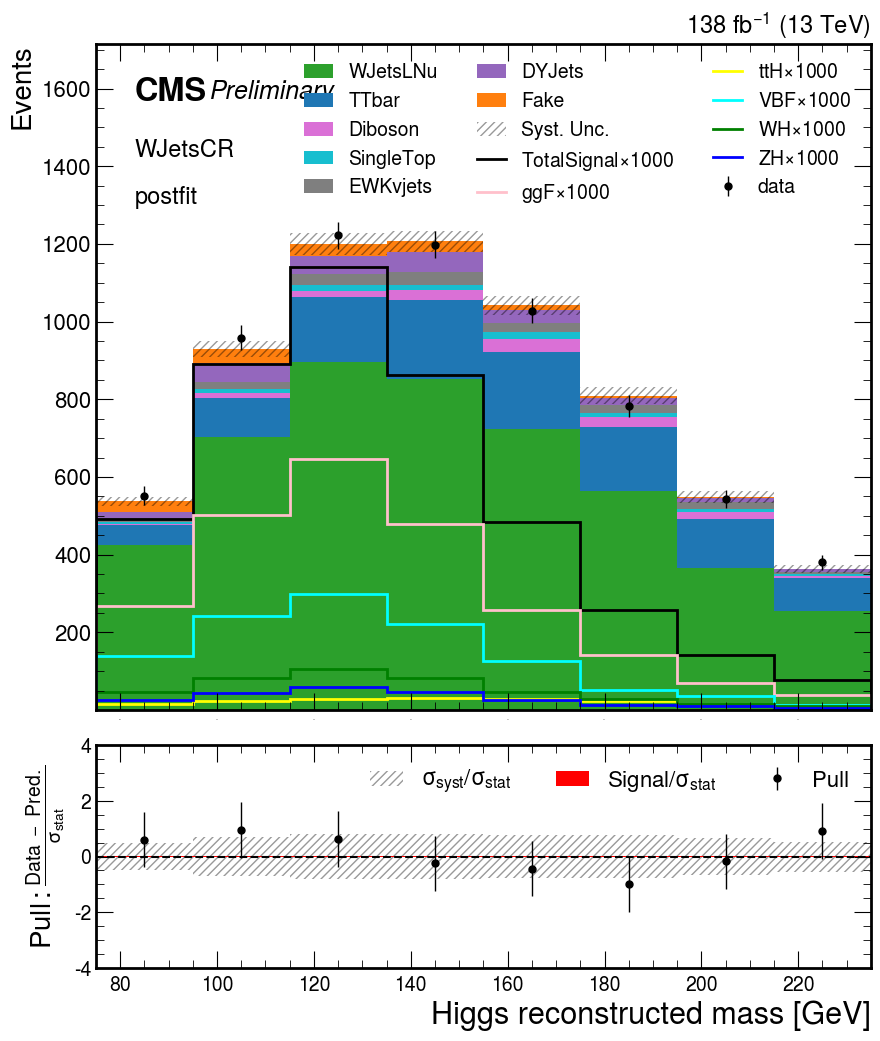

In [31]:
def fitshapes_runPlots_1lep(region = "PS", reg_str = f"_{FIT}",nametext = "", othertext = "",year=f"{YEAR}"): 
    arrays,arrays_var = load_fitshapes(region = region,reg_str = reg_str)
    fitshapes_plot_1lep(arrays,arrays_var,  region = region, nametext = nametext, othertext = othertext,plot_name='MH_Reco', x_name=f'Higgs reconstructed mass [GeV]', x_max=235, x_min=75, bins=8, year=year,deco = False)
    
fitshapes_runPlots_1lep(region = "VBF", othertext =  f"{FIT}")
fitshapes_runPlots_1lep(region = "ggFpt350to500", othertext =  f"{FIT}")
fitshapes_runPlots_1lep(region = "ggFpt250to350",   othertext = f"{FIT}")
fitshapes_runPlots_1lep(region = "ggFpt500toInf", othertext =  f"{FIT}")
fitshapes_runPlots_1lep(region = "TopCR", othertext =  f"{FIT}")
fitshapes_runPlots_1lep(region = "WJetsCR",   othertext = f"{FIT}")

### Plot VH